# ScientISST MOVE: Getting Started in EDF format
Please cite:
_Saraiva et al., ScientISST MOVE: Annotated Multimodal Naturalistic Dataset Recorded During Everyday Life Activities Using Wearable Devices, Scientific Data (2024)_

**It is recommended you run this notebook in a virtual environment.**
On the terminal:

1. Create new virtual environment: `python -m venv venv`
2. Activate it: `source venv/bin/activate` on Linux/MacOS or `venv\Scripts\activate` on Windows
3. Associate this to a Jupyter kernel: `ipython kernel install --user --name=venv`
4. Restart the notebook and change the kernel to `venv` under the Kernel tab.

See full guide [here](https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/).

## A. Download Dataset
This might take a while...
Bellow, you might need to change to pip3 or pip, depending on your system.

In [1]:
!pip3 install wget
import wget, zipfile, os, ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Download dataset in EDF+ format
url = 'https://physionet.org/files/scientisst-move-biosignals/1.0.1/'
#url = 'https://zenodo.org/records/8300972/files/edf.zip?download=1'  # alternative link
filename = wget.download(url)  # into to the current directory

# Decompress zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith('edf/'):
            zip_ref.extract(file)

# Delete zip file
os.remove(filename)

100% [......................................................................] 217297423 / 217297423

## B. Install MNE

We'll use MNE to read the EDF files, for this library allows for easy plotting and preprocessing.
Bellow, you might need to change to pip3 or pip, depending on your system.

In [2]:
# Install MNE
!pip install mne  # comment this if already installed

  Using cached mne-1.6.1-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl.metadata (4.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
Using cached mne-1.6.1-py3-none-any.whl (8.3 MB)
Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.

## 1. Load and explore
Let's use subject LAS2 as an example. Consider we will need only the wrist data for this project.

In [3]:
import mne

code = 'LAS2'
path = f'edf/{code}/empatica.edf'

# open with mne
raw = mne.io.read_raw_edf(path, preload=True)
raw

Extracting EDF parameters from /Users/saraiva/Desktop/test/edf/LAS2/empatica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 221119  =      0.000 ...  3454.984 secs...


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,LAS2
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,64.00 Hz
Highpass,0.00 Hz
Lowpass,32.00 Hz


Above we can see a tabular description of the EDF+ file. From this we can gather that it has 6 channels (ignore EEG word), with 44 minutes recording (not necessarily useful), and the maximum sampling frequency is 64 Hz. The channels are:

In [4]:
# Channel names
for ch in raw.info['chs']:
    print(ch['ch_name'])

eda:dry
acc_e4:z
acc_e4:x
acc_e4:y
ppg:wrist
temp


We can also get information about the annotations:

In [5]:
print('Label\tOnset\tDuration')
for a in raw.annotations:
    print(f"{a['description']} \t{a['onset']} \t{a['duration']}")

Label	Onset	Duration
lift-1 	70.42 	39.796
lift-2 	290.09 	52.985
greetings 	374.75 	38.44
jumps 	413.19 	27.946
gesticulate 	482.3 	75.745
walk_before_elevatordown 	1023.83 	111.242
walk_before 	1135.072 	563.928
run 	1699.0 	1710.556


Let's get a quick sneak-peak of the accelerometer signals during the greetings activity:

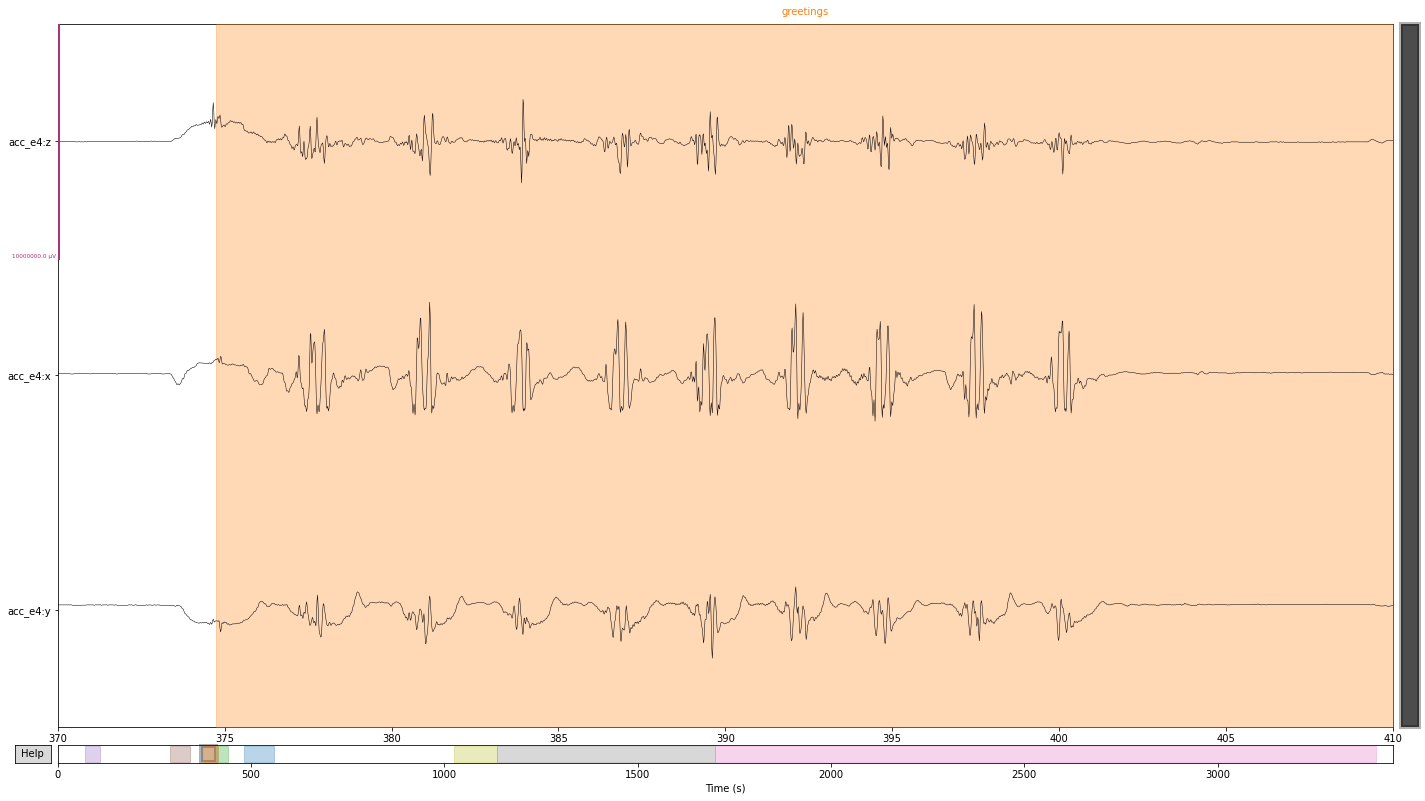

In [8]:
mne.viz.set_browser_backend('matplotlib')
_ = raw.plot(start=370, duration=40, scalings=5, order=(1,2,3), show=True)  # ACC channels

Notice the periodic handshakes in the signal.

Be careful with the scalings as these are different units (ACC in g, EDA in uS, TEMP in ºC). In interactive mode you can navigate through the acquisition.

## 2. Index channels and activities
Awsome! Let's see the EDA and TEMP when the subject was lifting a chair. Recall the events annotated and their names:

In [9]:
# Pick channels
eda_temp = raw.copy().pick(['eda:dry', 'temp'])

In [10]:
# Crop by activity
lift_annotation = mne.Annotations(**raw.annotations[1])
eda_temp_lift = eda_temp.crop_by_annotations(lift_annotation)[0]  # trim the raw data to the annotation

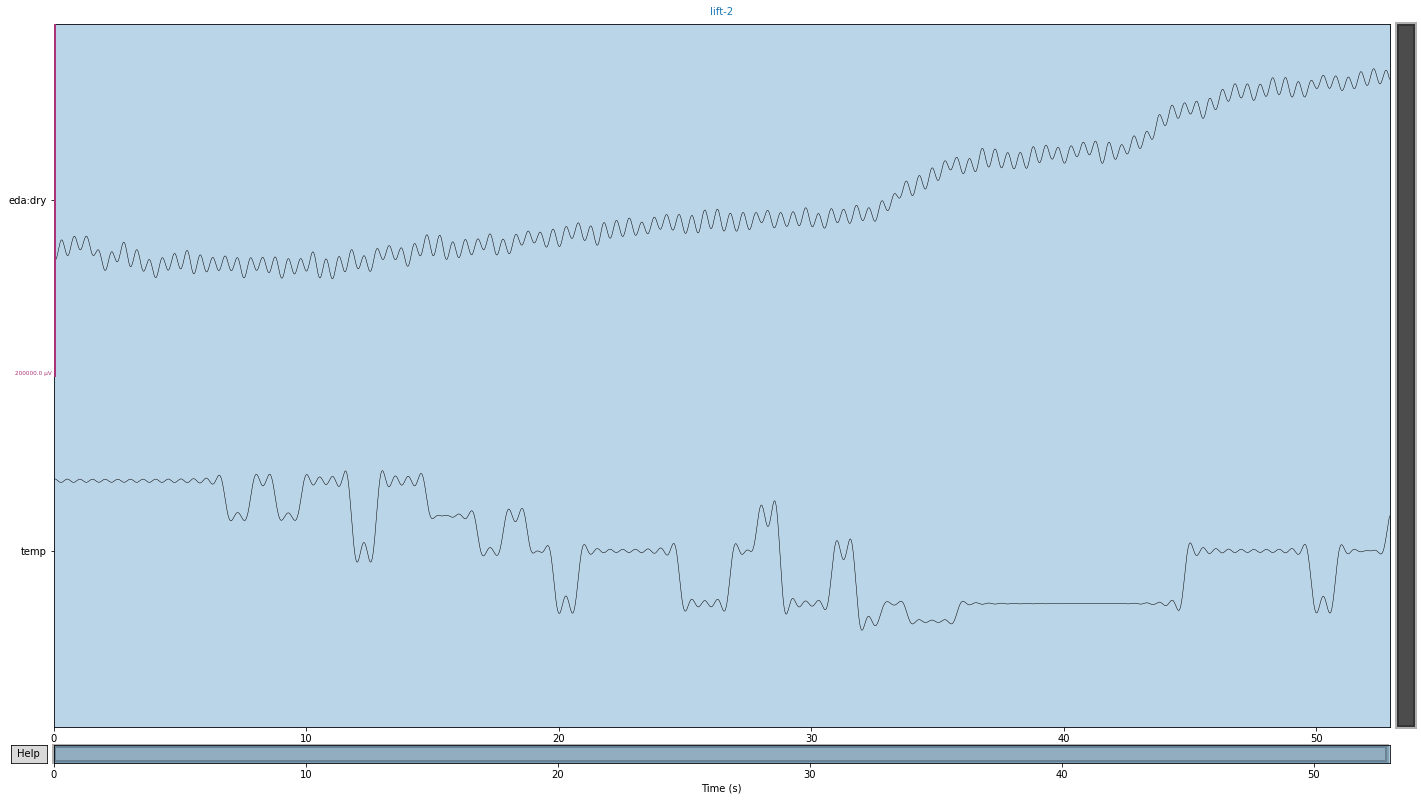

In [11]:
_ = eda_temp_lift.plot(start=0, duration=52.9, scalings=1e-1)

We can notice an increase in sweat release at the wrist, and a slight decrease in temperature recorded at the wrist.

In [12]:
# Get max, min and mean temperature during Lift
temp = eda_temp_lift.get_data()[1]
print("Temperature (ºC)")
print(f"Max: {temp.max()}\nMin: {temp.min()}\nMean: {temp.mean()}")

Temperature (ºC)
Max: 32.075668453930774
Min: 31.98483142415168
Mean: 32.02988174260024


## 3. Process a raw EDF
MNE offers a diverse set of post-processing tools.
Let's filter the EDA and TEMP signals wih a simple FIR lowpass at 2 Hz:

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 1.99 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.99 Hz)
- Filter length: 107 samples (1.672 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


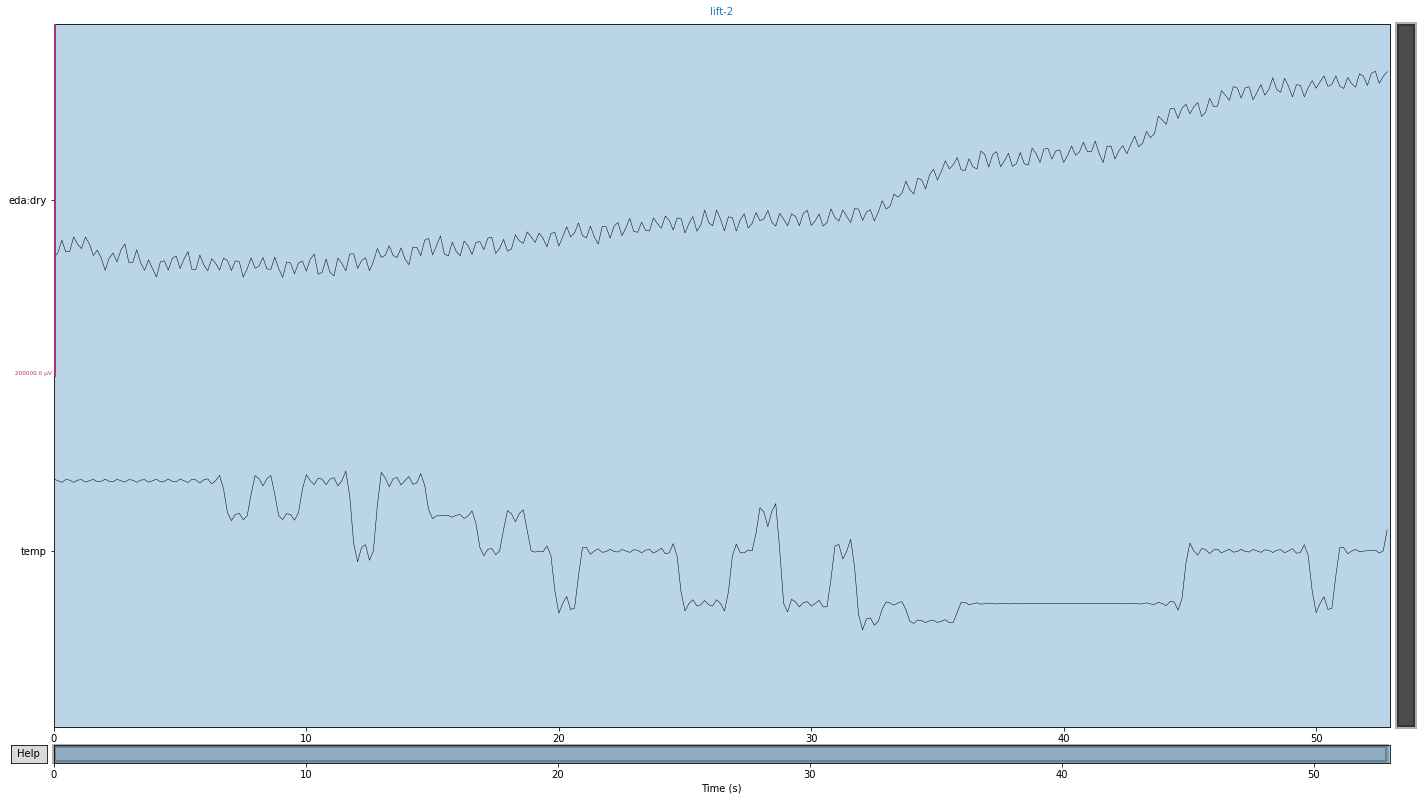

In [13]:
eda_temp_lift.filter(0, 1.99)
_ = eda_temp_lift.plot(start=0, duration=52.9, scalings=1e-1)

Let's normalize it:

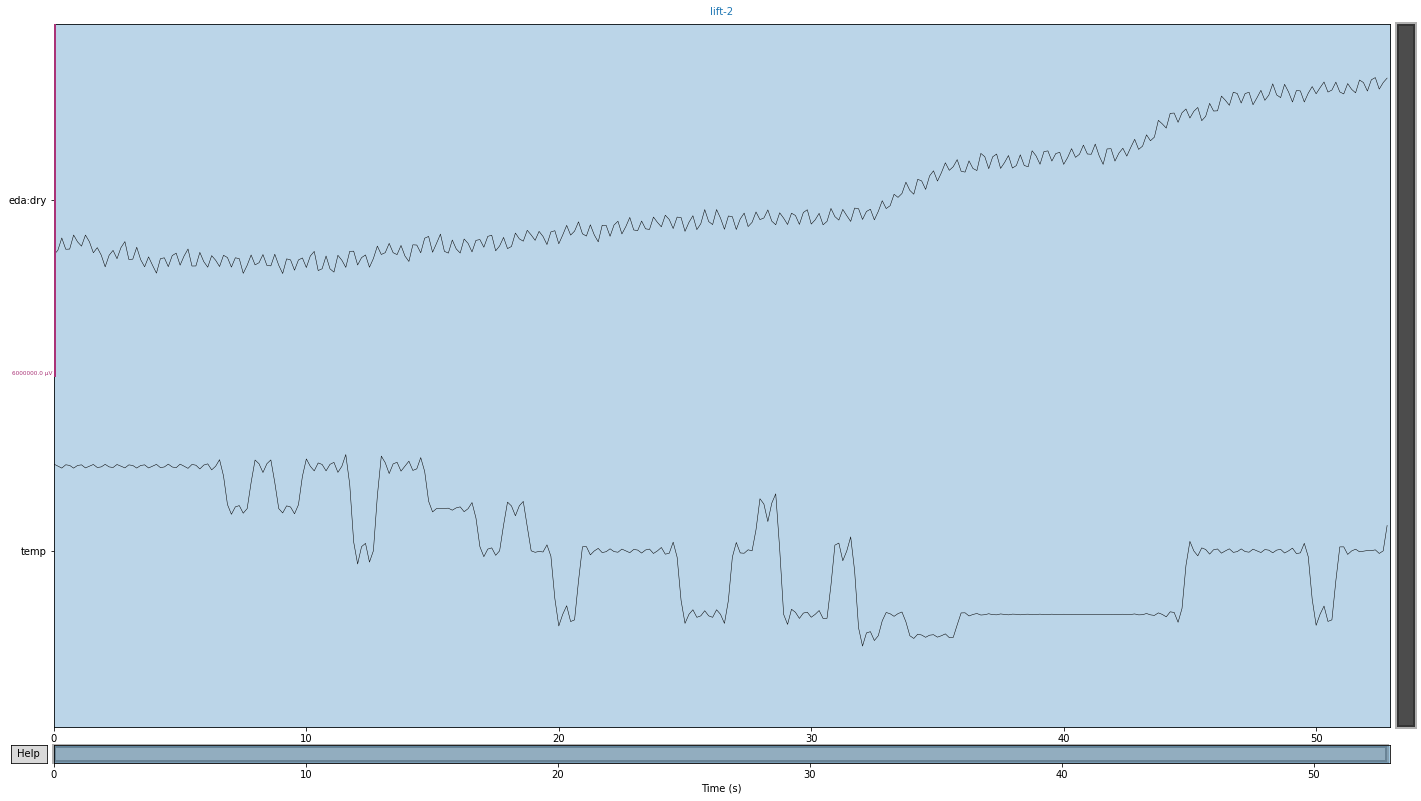

In [14]:
eda_temp_lift.apply_function(lambda x: (x - x.mean()) / x.std())
_ = eda_temp_lift.plot(start=0, duration=52.9, scalings=3)

MNE was designed for EEG, MEG and MRI, but it can still be used for storing other biosignals (ECG, RESP, GSR, EMG, TEMP, etc.). You can inclusively state the type of each channel. Let's state the ECG and ACC channel types:

In [15]:
eda_temp_lift = eda_temp_lift.set_channel_types({'eda:dry': 'gsr', 'temp': 'temperature'})
eda_temp_lift

/var/folders/1g/sc9mrb8x18s7r9d97p9glqch0000gp/T/ipykernel_57799/1125524921.py:1: RuntimeWarning: The unit for channel(s) eda:dry has changed from V to S.
  eda_temp_lift = eda_temp_lift.set_channel_types({'eda:dry': 'gsr', 'temp': 'temperature'})
/var/folders/1g/sc9mrb8x18s7r9d97p9glqch0000gp/T/ipykernel_57799/1125524921.py:1: RuntimeWarning: The unit for channel(s) temp has changed from V to C.
  eda_temp_lift = eda_temp_lift.set_channel_types({'eda:dry': 'gsr', 'temp': 'temperature'})


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,LAS2
Digitized points,Not available
Good channels,"1 Galvanic skin response, 1 Temperature"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,64.00 Hz
Highpass,0.00 Hz
Lowpass,1.99 Hz


## 4. Stepping out of MNE

You can also convert it to NumPy array and keep going from there:

In [19]:
eda_temp_lift.get_data()

array([[-0.94050127, -0.94644882, -0.95128692, ...,  1.90259265,
         1.87839824,  1.85408208],
       [ 1.48567132,  1.48441844,  1.4829695 , ...,  0.80360145,
         0.83197628,  0.8595724 ]])

Or to a Pandas DataFrame:

In [20]:
!pip3 install pandas
eda_temp_lift.to_data_frame()

,time,eda:dry,temp
0,0.000000,-0.940501,1.485671
1,0.015625,-0.946449,1.484418
2,0.031250,-0.951287,1.482970
3,0.046875,-0.953975,1.481143
4,0.062500,-0.953609,1.478787
...,...,...,...
3387,52.921875,1.950021,0.741691
3388,52.937500,1.926525,0.773718
3389,52.953125,1.902593,0.803601
3390,52.968750,1.878398,0.831976


________
© 2023 ScientISST. All rights reserved.

Notebook offered by the [LTBio team](https://github.com/jomy-kk/LTBio).
Contact: joaomiguelsaraiva@tecnico.ulisboa.pt